In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
sns.set()
import time

from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample

import statsmodels.api as sm
from statsmodels.api import OLS
import gpytorch
import torch
from GPPred import GPPred, ExactGPModel
from GPPred import CalibrateModels
from sklearn.metrics import mean_squared_error
%matplotlib inline


plt.style.use('seaborn-whitegrid')

/var/folders/l4/8m8mc77d711b218kpn3nm8sc0000gn/T/ipykernel_21672/2260735909.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [265]:
# # Define the function
# def non_smooth_function(x):
#     conditions = [x < -2, (x >= -2) & (x < 0), (x >= 0) & (x < 2), x >= 2]
#     functions = [lambda x: np.sin(x),  # Smooth, but with a jump to the next segment
#                  lambda x: -1,        # Constant, creating a jump from the previous segment
#                  lambda x: 0.5*x,     # Linear, creating a discontinuity from the constant segment
#                  lambda x: np.sin(x) + 2]  # Jump and offset from the previous linear segment
#     return np.piecewise(x, conditions, functions)

# # Generate sample data
# x = np.linspace(-10, 10, 400)
# y = non_smooth_function(x)

# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, label='Non-Smooth Function')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Example of a Non-Smooth Function for GPR Challenges')
# plt.legend()
# plt.show()


In [266]:
def GP_predict(test_x, kernel_type, x, y, optimal_lengthscale, optimal_outputscale, optimal_noise):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1.000E-06))
    model = ExactGPModel(x, y, likelihood, kernel_type)

    # assign the optimal hyperparameters
    model.covar_module.base_kernel.lengthscale = optimal_lengthscale
    model.covar_module.outputscale = optimal_outputscale
    model.likelihood.noise = optimal_noise
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        observed_pred = model(test_x)
        observed_pred_with_noise = likelihood(observed_pred) 
    
    return observed_pred, observed_pred_with_noise


In [267]:
# # Define the function
# def non_smooth_function(x):
#     conditions = [x<-4, (x >= -4) & (x < -2), (x >= -2) & (x < 0), (x >= 0) & (x < 2), (x >= 2) & (x < 4), x>4]
#     functions = [
#                  lambda x: -x - 4,  # Smooth, but with a jump to the next segment
#                  lambda x: 4 + x,  # Smooth, but with a jump to the next segment
#                  lambda x: -x,        # Constant, creating a jump from the previous segment
#                  lambda x: x,     # Linear, creating a discontinuity from the constant segment
#                  lambda x: 4 - x,  # Jump and offset from the previous linear segment
#                  lambda x: x - 4
#     ]
#     return np.piecewise(x, conditions, functions)

# # Generate sample data
# x = np.linspace(-10, 10, 400)
# y = non_smooth_function(x)

# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, label='Non-Smooth Function')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Example of a Non-Smooth Function for GPR Challenges')
# plt.legend()
# plt.show()


/var/folders/l4/8m8mc77d711b218kpn3nm8sc0000gn/T/ipykernel_21672/990075078.py:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sqrt(2**k/((lengthscale**(2*k))*np.math.factorial(k)))*np.power(x, k)*np.exp(-(np.power(lengthscale, -2)*x**2))


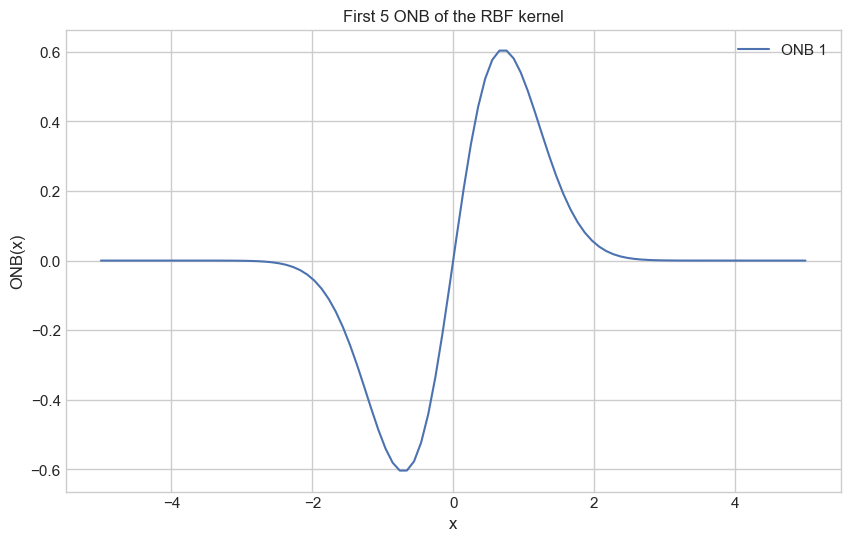

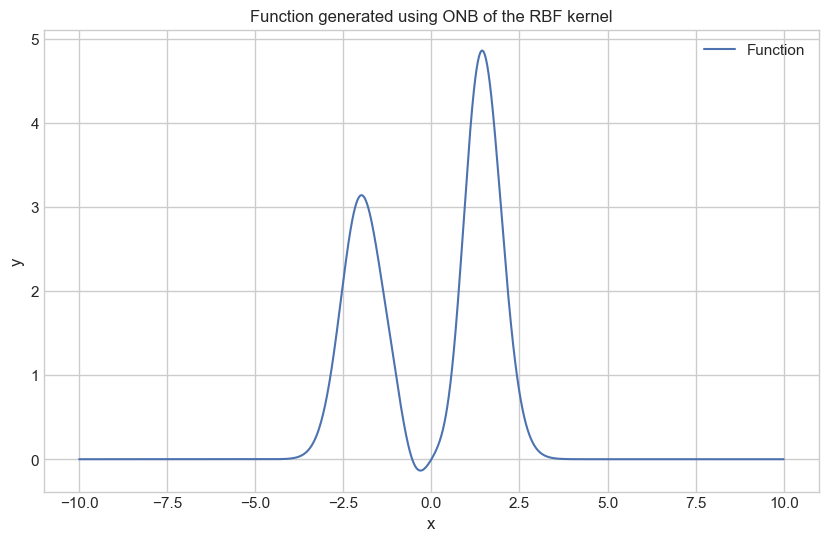

In [470]:
## define the ONB of the RBF kernels
def ONB_RBF_kernel(x, lengthscale, k):
    return np.sqrt(2**k/((lengthscale**(2*k))*np.math.factorial(k)))*np.power(x, k)*np.exp(-(np.power(lengthscale, -2)*x**2))

# plot the first 5 ONB of the RBF kernel
x = np.linspace(-5, 5, 100)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
for i in range(1, 2):
    ax.plot(x, ONB_RBF_kernel(x, 1.0, i), label=f'ONB {i}')
ax.legend()
ax.set_title('First 5 ONB of the RBF kernel')
ax.set_xlabel('x')
ax.set_ylabel('ONB(x)')
plt.show()


def generate_rbf_rkhs_function(x, N=10):
    N = N + 1
    mesh_size = len(x)
    coefficients = np.random.normal(size=N) * 3
    y = np.zeros(mesh_size)
    # normalize the coefficients
    # coefficients = coefficients/np.linalg.norm(coefficients)
    for i in range(1, N):
        # y += coefficients[i]*ONB_RBF_kernel(x, 1.0, i)
        y += coefficients[i]*ONB_RBF_kernel(x, 1.0, i)
    return y, coefficients
# generate a function using 1-5 and 20-25 ONB of the RBF kernel using
# random coefficients
mesh_size = 5000
x = np.linspace(-10, 10, mesh_size)
y, coefficients = generate_rbf_rkhs_function(x, N=10)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))    
ax.plot(x, y, label='Function')
ax.legend()
ax.set_title(f'Function generated using ONB of the RBF kernel')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [471]:
# # Define the function
# def more_non_smooth_function(x):
#     conditions = [
#         x < -5,                                      # Region 1
#         (x >= -5) & (x < -2),                        # Region 2
#         (x >= -2) & (x < 0),                         # Region 3
#         (x >= 0) & (x < 2),                          # Region 4
#         (x >= 2) & (x < 5),                          # Region 5
#         x >= 5                                        # Region 6
#     ]
#     functions = [
#         lambda x: np.abs(x) - 5,                     # Absolute value, creating a corner at x = -5
#         lambda x: np.sin(3*x),                       # High frequency sine wave for complexity
#         lambda x: np.log(np.abs(x+2)),               # Logarithmic, introducing a vertical asymptote at x = -2
#         lambda x: 2 * np.piecewise(x, [x < 1, x >= 1], [lambda x: x, lambda x: 0]), # Piecewise linear with a break
#         lambda x: -2 + (x-2)**2,                     # Quadratic, smooth but with a different curvature
#         lambda x: 20 * np.sin(x) / x                 # Sinc function, introducing oscillations
#     ]
#     return np.piecewise(x, conditions, functions)

# # Generate sample data
# x = np.linspace(-10, 10, 1000)
# y = more_non_smooth_function(x)

# # Plot
# plt.figure(figsize=(12, 7))
# plt.plot(x, y, label='More Non-Smooth Function')
# plt.xlabel('x')
# plt.ylabel('y')



### Data Mismeasurement

/var/folders/l4/8m8mc77d711b218kpn3nm8sc0000gn/T/ipykernel_21672/990075078.py:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sqrt(2**k/((lengthscale**(2*k))*np.math.factorial(k)))*np.power(x, k)*np.exp(-(np.power(lengthscale, -2)*x**2))


Norm of y_true: 39.02354343429736


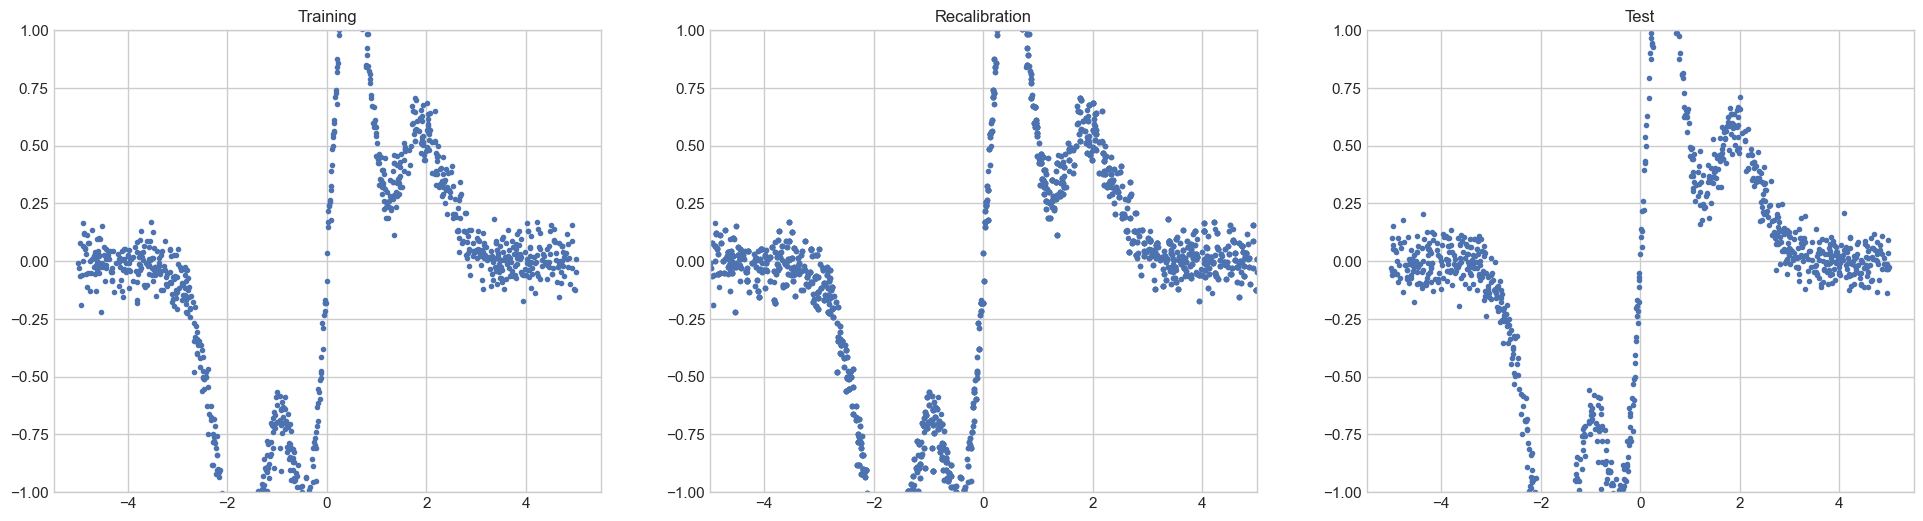

In [472]:
n = 4000
n_per = 1000
all_x = np.linspace(-5, 5, n)
# y = 0.00005*x**5*(np.abs(x))*np.cos(x)*np.log(np.abs(x)) + np.random.normal(scale=1.0,size=n)
# y = 0.00005*x**7 + np.random.normal(scale=0.5,size=n)
np.random.seed(123)
# y = non_smooth_function(x) + np.random.normal(scale=0.5,size=n)
# use noise from student-t distribution instead of normal
# y = non_smooth_function(x) + 0.5*st.t.rvs(3, size=n)
# eval and test dataset

## generate a function using the first N components of the ONB of the RBF kernel
N = 5
all_y_true, coefficients = generate_rbf_rkhs_function(all_x, N=N)
# compute and print the norm of y_true
print(f'Norm of y_true: {np.linalg.norm(all_y_true)}')
all_y_without_noise = all_y_true
all_y = all_y_true + np.random.normal(scale=np.max(all_y_true)*0.05,size=n)
x, x_test, y, y_test = train_test_split(all_x,all_y,train_size=0.5)
x, x_eval, y, y_eval = train_test_split(x,y,train_size=0.5)
x_test, y_test = x_test[0:n_per], y_test[0:n_per]

# downsample x, y using only 0.3 of the data
# x, y = resample(x,y,n_samples=int(0.1*n))



add_noise = 0.00
# adding some noise
y_eval += np.random.normal(scale=add_noise,size=n_per)
y_test += np.random.normal(scale=add_noise,size=n_per)



# sorting
inds_x, inds_eval, inds_test = np.argsort(x), np.argsort(x_eval), np.argsort(x_test)
x, y = x[inds_x], y[inds_x]
x_eval, y_eval = x_eval[inds_eval], y_eval[inds_eval]
x_test, y_test = x_test[inds_test], y_test[inds_test]


# # downsample x_eval, y_eval using only 0.1 of the data from beginning , middle and end 
x_eval, y_eval = resample(x,y,n_samples=int(n))
# sample_size = 0.05
# steps_1 = 2
# steps_2 = 10
# tmp_x_eval, tmp_y_eval = x_eval[0:int(sample_size*n):
# steps_1], y_eval[0:int(sample_size*n):steps_1]
# tmp_x_eval, tmp_y_eval = np.append(tmp_x_eval, x_eval[int(sample_size*n):-int(sample_size*n):steps_2]), np.append(tmp_y_eval, y_eval[int(sample_size*n):-int(sample_size*n):steps_2])
# x_eval, y_eval = np.append(tmp_x_eval, x_eval[-int(sample_size*n):-1:steps_1]), np.append(tmp_y_eval, y_eval[-int(sample_size*n):-1:steps_1])

# assert x.shape == x_eval.shape and x_eval.shape == x_test.shape and x_test.shape[0] == n_per

# plotting x and y
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6))


y_lower_lim = -1
y_upper_lim = 1
# training
ax[0].plot(x, y, 'o', markersize=3)
ax[0].set_title('Training')
ax[0].set_ylim([y_lower_lim, y_upper_lim])

# eval
ax[1].plot(x_eval, y_eval, 'o', markersize=3)
ax[1].set_title('Recalibration')
ax[1].set_ylim([y_lower_lim, y_upper_lim])
ax[1].set_xlim([x[0], x[-1]])

# test
ax[2].plot(x_test, y_test, 'o', markersize=3)
ax[2].set_title('Test')
ax[2].set_ylim([y_lower_lim, y_upper_lim]);

---

### Gaussian Processes Regression

In [537]:
# transform all data to tensors
x = torch.tensor(x).float()
y = torch.tensor(y).float()
x_eval = torch.tensor(x_eval).float()
y_eval = torch.tensor(y_eval).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()


/var/folders/l4/8m8mc77d711b218kpn3nm8sc0000gn/T/ipykernel_21672/1507528573.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).float()
/var/folders/l4/8m8mc77d711b218kpn3nm8sc0000gn/T/ipykernel_21672/1507528573.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()


In [538]:
kernel_type = 'Matern1/2'
GP = GPPred(x, y, kernel_type=kernel_type)
GP.trainGP(n_iter = 100)

# simple the misspecification
# GP.model.covar_module.outputscale = GP.model.covar_module.outputscale
# GP.model.covar_module.outputscale  = torch.Tensor([8.0])
# GP.model.likelihood.noise = GP.model.likelihood.noise * 0.01
# optimal_lengthscale = GP.model.covar_module.base_kernel.lengthscale.detach()
# optimal_outputscale = GP.model.covar_module.outputscale.detach()
optimal_noise = GP.model.likelihood.noise.detach()
# print(GP.model.covar_module.outputscale, GP.model.covar_module.base_kernel.lengthscale, GP.model.likelihood.noise)
# GP.model.covar_module.base_kernel.lengthscale = GP.model.covar_module.base_kernel.lengthscale * 1
# GP.model.covar_module.outputscale = GP.model.covar_module.outputscale * 1
GP.model.likelihood.noise = GP.model.likelihood.noise * 1


# predict on the training set
y_pred_dist, y_pred_with_noise_dist = GP.predict(x)
y_pred = y_pred_dist.mean
y_pred_std = y_pred_with_noise_dist.stddev


# predict on the evaluation set
y_eval_pred_dist, y_eval_pred_with_noise_dist = GP.predict(x_eval)
y_eval_pred = y_eval_pred_dist.mean
y_eval_pred_std = y_eval_pred_with_noise_dist.stddev



# predict on the test set
# GP.model.covar_module.base_kernel.lengthscale = torch.Tensor([2.633])
y_test_pred_dist, y_test_pred_with_noise_dist = GP.predict(x_test)
y_test_pred = y_test_pred_dist.mean
y_test_pred_std = y_test_pred_with_noise_dist.stddev
lower, upper = y_test_pred - 1.96*y_test_pred_std, y_test_pred + 1.96*y_test_pred_std



# transform all data to back to numpy
x = x.numpy()
y = y.numpy()
x_eval = x_eval.numpy()
y_eval = y_eval.numpy()
x_test = x_test.numpy()
y_test = y_test.numpy()
y_pred = y_pred.numpy()
y_pred_std = y_pred_std.numpy()
y_eval_pred = y_eval_pred.numpy()
y_eval_pred_std = y_eval_pred_std.numpy()
y_test_pred = y_test_pred.numpy()
y_test_pred_std = y_test_pred_std.numpy()
lower = lower.numpy()
upper = upper.numpy()

44.5% of the points in the 95% PI


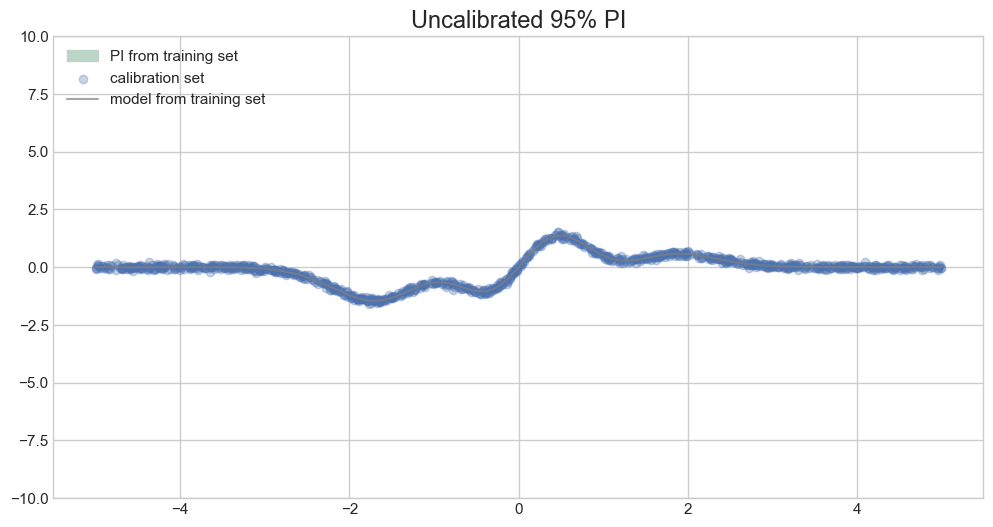

In [539]:
CalibrateModel = CalibrateModels()
CalibrateModel.plot_CI(x_test, y_test, y_test_pred, lower, upper)


In [540]:
# misspecification checking

def misspecification_checking(x, y, coefficients, kernel_type = 'RBF', n_iter=100, n_runs = 5, delta=0.95):
    # add noise to y 
    training_proportion = 0.8
    # split x, y, cleaned_y into training and test set
    x, x_test, cleaned_y, y_true= train_test_split(x, y, train_size=training_proportion)

    # x, x_test, y, y_true = train_test_split(x,y,train_size=training_proportion)
    n_train = len(x)
    n_test = len(x_test)
    # creat a probability table for each test location for all runs
    prob_table = np.zeros((n_runs, n_test))
    probs = []
    for l in range(n_runs):
        # randomly sample 500 points from the training set
        np.random.seed(int(time.time()))
        y = cleaned_y + np.random.normal(scale=0.5,size=len(cleaned_y))
        # define the exact GP model
        class ExactGPModel(gpytorch.models.ExactGP):
            def __init__(self, train_x, train_y, likelihood, kernel_type):
                super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
                self.mean_module = gpytorch.means.ZeroMean()
                if kernel_type == 'RBF':
                    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
                elif kernel_type == 'Matern5/2':
                    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
                elif kernel_type == 'Matern3/2':
                    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
                elif kernel_type == 'Matern1/2':
                    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))
                elif kernel_type == 'Linear':
                    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
                elif kernel_type == 'Periodic':
                    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
                elif kernel_type == 'Cosine':
                    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel())
                elif kernel_type == 'RationalQuadratic':
                    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQ())
                elif kernel_type == 'PiecewisePolynomialKernel':
                    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PiecewisePolynomialKernel())
                else:
                    raise ValueError('Invalid kernel type')
                self.likelihood = likelihood

            def forward(self, x):
                mean_x = self.mean_module(x)
                covar_x = self.covar_module(x)
                return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1.000E-06))
        model = ExactGPModel(x, y, likelihood, kernel_type)
        # train the GP model
        model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for i in range(n_iter):
            optimizer.zero_grad()
            output = model(x)
            loss = -mll(output, y)
            loss.backward()
            optimizer.step()
        print(f'The {i}th iteration loss is {loss.item()}')

        # get the optimal hyperparameters
        # optimal_lengthscale = GP.model.covar_module.base_kernel.lengthscale.detach()
        # optimal_outputscale = GP.model.covar_module.outputscale.detach()
        optimal_noise = model.likelihood.noise.detach()
        truncated_noise = max(1, np.sqrt(optimal_noise))

        model.eval()
        likelihood.eval()
        with torch.no_grad():
            # predict on the training set
            y_pred_dist = likelihood(model(x))
            y_pred = y_pred_dist.mean.numpy()
            y_pred_std = y_pred_dist.stddev
            # predict on the test set
            y_test_pred_with_noise_dist = likelihood(model(x_test))
            y_test_pred = y_test_pred_with_noise_dist.mean.numpy()
            y_test_pred_std = y_test_pred_with_noise_dist.stddev.numpy()
        
        tmp_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1.000E-06))
        # tmp_model = ExactGPModel(x, cleaned_y, tmp_likelihood, kernel_type)
        tmp_model = ExactGPModel(x, y_pred_std, tmp_likelihood, kernel_type)
        # tmp_model = ExactGPModel(x, y-cleaned_y, tmp_likelihood, kernel_type)
        # assign the hyperparameter of the trained model to the tmp model same as pytorch
        tmp_model.load_state_dict(model.state_dict())
    
        
        # predict on the training set
        tmp_model.eval()
        tmp_likelihood.eval()
        with torch.no_grad():
            # predict on the test set
            y_test_pred_with_noise_dist = tmp_likelihood(tmp_model(x_test))
            noise_y_test_pred = y_test_pred_with_noise_dist.mean.numpy()
            noise_y_test_pred_std = y_test_pred_with_noise_dist.stddev.numpy()
        

        # compute the difference metric
        upper_bound  = 0
        # first compute the rkhs norm of the function
        rkhs_norm = np.sqrt(np.sum(np.power(coefficients, 2)))
        # print(rkhs_norm)
        # compute the logdet of logdet|truncated noise/noise * covariance matrix + truncated noise * indeitity matrix|
        # sign, logdet = np.linalg.slogdet(truncated_noise * np.eye(n_train) + y_pred_dist.lazy_covariance_matrix.evaluate().detach().numpy())  
        # upper_bound = 1/optimal_noise * np.sqrt(logdet*sign - 2*np.log(delta))
        # upper_bound = upper_bound * y_test_pred_std
        # upper_bound = rkhs_norm * y_test_pred_std
        # upper_bound =  upper_bound + np.abs(cleaned_y_test_pred - y_true.numpy())
        # print(max(np.abs(y - y_pred)).numpy())
        # upper_bound = np.min(np.abs(cleaned_y - y_pred).numpy()) + np.abs(cleaned_y_test_pred)
        upper_bound = 1.0
        print(upper_bound)
        # compute the probability which is the proportion of the test set that falls within the upper bound
        # pred_err = np.abs(y_test_pred - (y_test.numpy() - y_test_pred_std))
        pred_err = np.abs(y_test_pred - y_true.numpy())/np.abs(noise_y_test_pred)
        print(pred_err)
        # store the prob table for each test loaction
        # prob = pred_err<=upper_bound
        # prob = pred_err/upper_bound
        # prob_table[l,:] = prob
        prob = np.sum(pred_err<=upper_bound)/n_test
        probs.append(prob)
    
       
    # compute the mean and std from the boostraped probabilities
    # avg_prob = np.mean(prob_table, axis=0)
    # std_prob = np.std(prob_table, axis=0)
    # for each test location, compute the probability that the prediction error is within the upper bound
    # num_accept = np.sum((1- delta < avg_prob + 1.96*std_prob)&(avg_prob - 1.96*std_prob < 1 - delta))
    avg_prob = np.mean(probs)
    std_prob = np.std(probs)

    # check if delta is in the confidence interval
    check = 'Accept' if ((avg_prob - 1.96*std_prob) < delta and delta < (avg_prob + 1.96*std_prob))  else 'Reject'
    return avg_prob, std_prob, check  #prob_table #avg_prob#, std_prob, num_accept

In [541]:
n = 500
np.random.seed(int(time.time()))
x, y= resample(all_x, all_y_true ,n_samples=n)
x = torch.tensor(x)
y = torch.tensor(y)
avg_prob, std_prob, check = misspecification_checking(x, y, coefficients, kernel_type = 'Matern3/2', n_iter=50, n_runs = 10, delta=0.95)

The 49th iteration loss is 0.8125280569915648
8.261889557986555
1.0
[0.16007211 0.14838167 0.2614762  0.54237636 0.32491203 0.49074623
 0.39823034 0.14858062 0.08609822 0.23354714 0.37678604 0.0791641
 0.2007258  0.30371446 0.04219711 0.04373758 0.01136472 0.22096586
 0.15105599 0.3278792  0.16105748 0.13621898 0.28642704 0.25681608
 0.34780443 0.05341985 0.04923855 0.48381294 0.29259466 0.36089755
 0.10400603 0.00097639 0.65696513 0.3875412  0.16547308 0.14230855
 0.16307536 0.10166434 0.18133651 0.31783807 0.24638091 0.11597117
 0.37226803 0.25238348 0.46618076 0.23893999 0.24493708 0.15932405
 0.26213685 0.11021636 0.00221273 0.40198721 0.0549325  0.20026767
 0.38398665 0.04683051 0.39911198 0.338999   0.08087384 0.33377523
 0.03251644 0.26388454 0.06689138 0.13019137 0.17468101 0.16314929
 0.08498874 0.07852889 0.23559582 0.02885017 0.16387131 0.02890998
 0.24468187 0.25963541 0.03283731 0.31107062 0.26047868 0.02070777
 0.22162951 0.01555215 0.30772215 0.25677167 0.24319763 0.0701

In [535]:
avg_prob, std_prob, check

(1.0, 0.0, 'Reject')